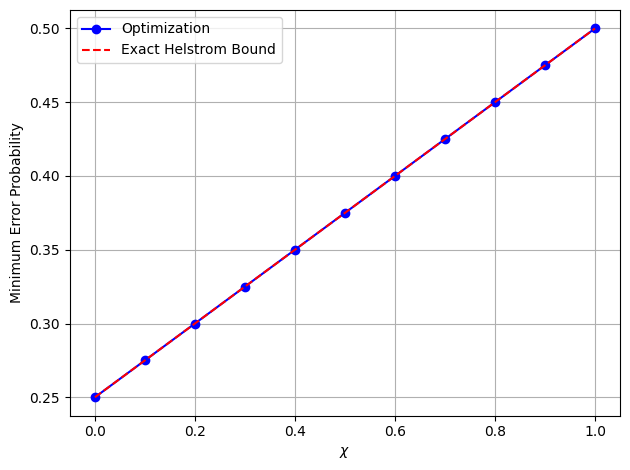

In [1]:
import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

def simplerho(v, alpha):

    sin_a = np.sin(alpha)
    cos_a = np.cos(alpha)

    vec_plus = sin_a * sigma_y + cos_a * sigma_z
    vec_minus = sin_a * sigma_y -  cos_a * sigma_z

    rho_plus = 0.5 * (I + (1 - v) * vec_plus)
    rho_minus = 0.5 * (I + (1 - v) * vec_minus)
    return rho_plus, rho_minus


def get_helstrom_operator(rho_plus, rho_minus, q=0.5):
    Delta = q * rho_plus - (1 - q) * rho_minus
    return Delta

# Construct general 2x2 unitary U
def construct_U(mu, nu, xi):
    return np.array([
        [np.exp(1j * mu) * np.cos(xi), np.exp(1j * nu) * np.sin(xi)],
        [-np.exp(-1j * nu) * np.sin(xi), np.exp(-1j * mu) * np.cos(xi)]
    ])

# Construct real diagonal D with entries in [0,1]
def construct_D(d1, d2):
    return np.diag([d1, d2])

# Objective function
def objective_fn(params, rho0, rho1, q=0.5):
    Delta = get_helstrom_operator(rho0,rho1)
    mu, nu, xi, d1, d2 = params
    U = construct_U(mu, nu, xi)
    D = construct_D(d1, d2)
    E0 = U.conj().T @ D @ D @ U

    # Optional: Project E0 back into [0,I] if needed
    eigvals, eigvecs = np.linalg.eigh(E0)
    eigvals = np.clip(eigvals, 0, 1)  # Just in case
    E0 = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T

    P_err = q - np.real(np.trace(Delta @ E0))
    return max(P_err, 0.0)

# Helstrom bound
def helstrom_bound(rho0, rho1, q=0.5):
    Delta = q * rho0 - (1 - q) * rho1
    eigvals = np.linalg.eigvalsh(Delta)
    return 0.5 * (1 - np.sum(np.abs(eigvals)))

# Updated bounds
bounds = [
    (0, 2 * np.pi),  # mu
    (0, 2 * np.pi),  # nu
    (0, np.pi / 2),  # xi
    (0, 1),          # d1
    (0, 1),          # d2
]

# Run optimization
v_values = np.linspace(0, 1, 11)
opt_results = []
helstrom_bounds = []


for v in v_values:
    #Delta = get_helstrom_operator(simplerho(v, alpha = np.pi/3)[0], simplerho(v, alpha = np.pi/3)[1])
    result = differential_evolution(objective_fn, bounds, args=(simplerho(v, alpha = np.pi/3)[0], simplerho(v, alpha = np.pi/3)[1]), strategy='best1bin', tol=1e-6, maxiter=1000)
    P_err_opt = result.fun
    P_err_exact = helstrom_bound(simplerho(v, alpha = np.pi/3)[0], simplerho(v, alpha = np.pi/3)[1])
    opt_results.append(P_err_opt)
    helstrom_bounds.append(P_err_exact)

# Plot
plt.plot(v_values, opt_results, 'bo-', label='Optimization')
plt.plot(v_values, helstrom_bounds, 'r--', label='Exact Helstrom Bound')
plt.xlabel(r'$\chi$')
plt.ylabel('Minimum Error Probability')
#plt.title(r'Comparison of Error Probabilities ($\alpha = \pi/6$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
opt_results

[np.float64(0.06698729810961718),
 np.float64(0.11028856833444739),
 np.float64(0.15358983849817842),
 np.float64(0.19689110869666943),
 np.float64(0.24019237886466838),
 np.float64(0.2834936490912322),
 np.float64(0.3267949192645582),
 np.float64(0.37009618945518785),
 np.float64(0.41339745988636145),
 np.float64(0.4566987298107781),
 np.float64(0.5)]

In [24]:
helstrom_bounds

[np.float64(0.06698729810778059),
 np.float64(0.11028856829700251),
 np.float64(0.15358983848622443),
 np.float64(0.19689110867544646),
 np.float64(0.24019237886466838),
 np.float64(0.2834936490538903),
 np.float64(0.3267949192431123),
 np.float64(0.37009618943233424),
 np.float64(0.41339745962155616),
 np.float64(0.4566987298107781),
 np.float64(0.5)]

In [2]:

from scipy.linalg import fractional_matrix_power

def error_exponent_objective(param, rho_plus, rho_minus):
    s = param[0]
    A = fractional_matrix_power(rho_plus, s)
    B = fractional_matrix_power(rho_minus, 1 - s)
    return np.real(np.trace(A @ B))

s_bound = [(0, 1)]


error_exponents = []
s_opts = []
for v in v_values:
    res = differential_evolution(
        error_exponent_objective,
        s_bound,
        args=(simplerho(v, alpha=np.pi/3)[0], simplerho(v, alpha=np.pi/3)[1]),
        strategy='best1bin',
        tol=1e-6,
        maxiter=1000
    )
    error_exponent = -np.log(res.fun)
    s_opt = res.x[0]
    error_exponents.append(error_exponent)
    s_opts.append(s_opt)




/var/folders/3d/dwvqd73528v67zty_cnbjttm0000gn/T/ipykernel_57295/3087468142.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


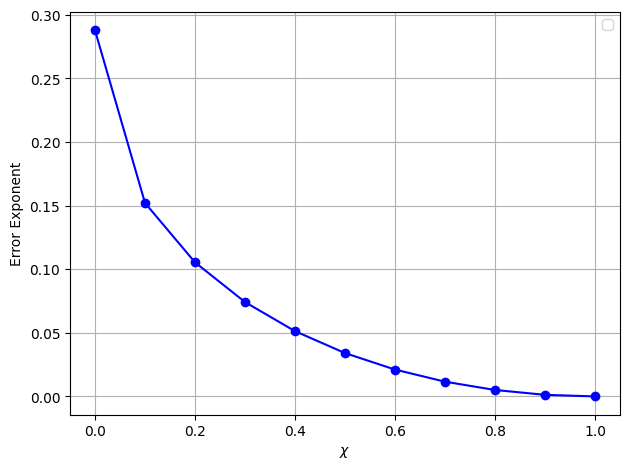

In [3]:
# Plot
plt.plot(v_values, error_exponents, 'bo-')
plt.xlabel(r'$\chi$')
plt.ylabel('Error Exponent')
#plt.title(r'Comparison of Error Probabilities ($\alpha = \pi/6$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
def detection_probability(rho0, rho1):
    result = differential_evolution(objective_fn, bounds, args=(rho0, rho1), strategy='best1bin', tol=1e-6, maxiter=1000)
    
    setup_params = result.x

    U = construct_U(setup_params[0], setup_params[1], setup_params[2]) # mu, nu, xi
    D = construct_D(setup_params[3], setup_params[4])
    E0 = U.conj().T @ D @ D @ U
    E1 = U.conj().T @ (np.identity(2) - D @ D) @ U

    # Optional: Project E0 back into [0,I] if needed
    eigvals0, eigvecs0 = np.linalg.eigh(E0)
    eigvals0 = np.clip(eigvals0, 0, 1)  # Just in case
    E0 = eigvecs0 @ np.diag(eigvals0) @ eigvecs0.conj().T

    eigvals1, eigvecs1 = np.linalg.eigh(E1)
    eigvals1 = np.clip(eigvals1, 0, 1)  # Just in case
    E1 = eigvecs1 @ np.diag(eigvals1) @ eigvecs1.conj().T

    # Prior probabilities
    q0 = 0.5
    q1 = 1 - q0

    # Choose which state is prepared
    prepared_state = rho0 if np.random.rand() < q0 else rho1

    # Compute measurement probabilities
    p0 = np.trace(prepared_state @ E0).real
    p1 = np.trace(prepared_state @ E1).real

    p0 = max(min(p0, 1.0), 0.0)
    p1 = 1.0 - p0

    # Simulate measurement
    #outcome = np.random.choice([0, 1], p=[p0, p1])
    #true_label = 0 if np.allclose(prepared_state, rho0) else 1
    #correct = (outcome == true_label)
    return prepared_state, p0, p1

def simulate_single_trial(N, prepared_state, rho0, p0, p1):
    true_label = 0 if np.allclose(prepared_state, rho0) else 1

    outcomes = []
    for _ in range(N):
        outcomes.append(np.random.choice([0,1], p = [p0,p1]))

    # majority vote
    guess = 0 if outcomes.count(0) > outcomes.count(1) else 1

    correct = (guess == true_label)
    return correct 

def estimate_error_exponent(N, trials, rho0, rho1, p0, p1, q=0.5):
    errors = 0
    for _ in range(trials):
        prepared_state = rho0 if np.random.rand() < q else rho1
        correct = simulate_single_trial(N, prepared_state, rho0, p0, p1)
        if not correct:
            errors += 1
    err_prob = errors / trials
    err_exponent = -np.log(err_prob) / N if err_prob > 0 else np.inf
    return err_prob, err_exponent





In [20]:
det = detection_probability(simplerho(0.4, np.pi/4)[0], simplerho(0.4, np.pi/4)[1])

In [ ]:
estimate_error_exponent(100, 1000000, simplerho(0.4, np.pi/4)[0], simplerho(0.4, np.pi/4)[1], det[1], det[2])